In [1]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2

import scdeepaa

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
dataset_name = 'MMD-MA'
dataset_color = 'lime'
modality_names = ['Modality 1', 'Modality 2']
data_folder = '../../JAMIE/examples/data/UnionCom/MMD/'
data1 = np.loadtxt(data_folder + "s1_mapped1.txt")
data2 = np.loadtxt(data_folder + "s1_mapped2.txt")
type1 = np.loadtxt(data_folder + "s1_type1.txt")
type2 = np.loadtxt(data_folder + "s1_type2.txt")
type1 = type1.astype(int)
type2 = type2.astype(int)
type1 = np.array([f'Cell Type {i}' for i in type1])
type2 = np.array([f'Cell Type {i}' for i in type2])

# Labels
labels = [type1, type2]
features = [None, None]
feature_dict = {}

In [4]:
res = scdeepaa.fit_deepAA(
    [data1, data2],
    [np.ones(data1.shape[0]), np.ones(data2.shape[0])],
    ["G", "G"],
    hidden_dims_dec_common = [128,64],
    hidden_dims_dec_last = [512],
    hidden_dims_enc_ind = [512],
    hidden_dims_enc_common = [256],
    hidden_dims_enc_pre_Z = [128, 64],
    lr = 0.001,
    gamma_lr = 0.01,
    steps = 2000,
    narchetypes = 3,
    batch_size = 200,
    fix_Z = False)

ELBO: -460411.33683  : 100%|██████████| 2000/2000 [00:56<00:00, 35.41it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


In [5]:
import scanpy as sc
import anndata as ad

In [6]:
data1_adata = ad.AnnData(data1)
data2_adata = ad.AnnData(data2)

sc.tl.pca(data1_adata, svd_solver='arpack')
sc.tl.pca(data2_adata, svd_solver='arpack')

sc.pp.neighbors(data1_adata)
sc.pp.neighbors(data2_adata)


sc.tl.umap(data1_adata)
sc.tl.umap(data2_adata)

/tmp/ipykernel_682684/429026265.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data1_adata = ad.AnnData(data1)
/tmp/ipykernel_682684/429026265.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data2_adata = ad.AnnData(data2)
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stab

In [7]:
data1_adata, arc_names1 = scdeepaa.add_to_obs_adata(res, data1_adata)
data2_adata, arc_names2 = scdeepaa.add_to_obs_adata(res, data2_adata)

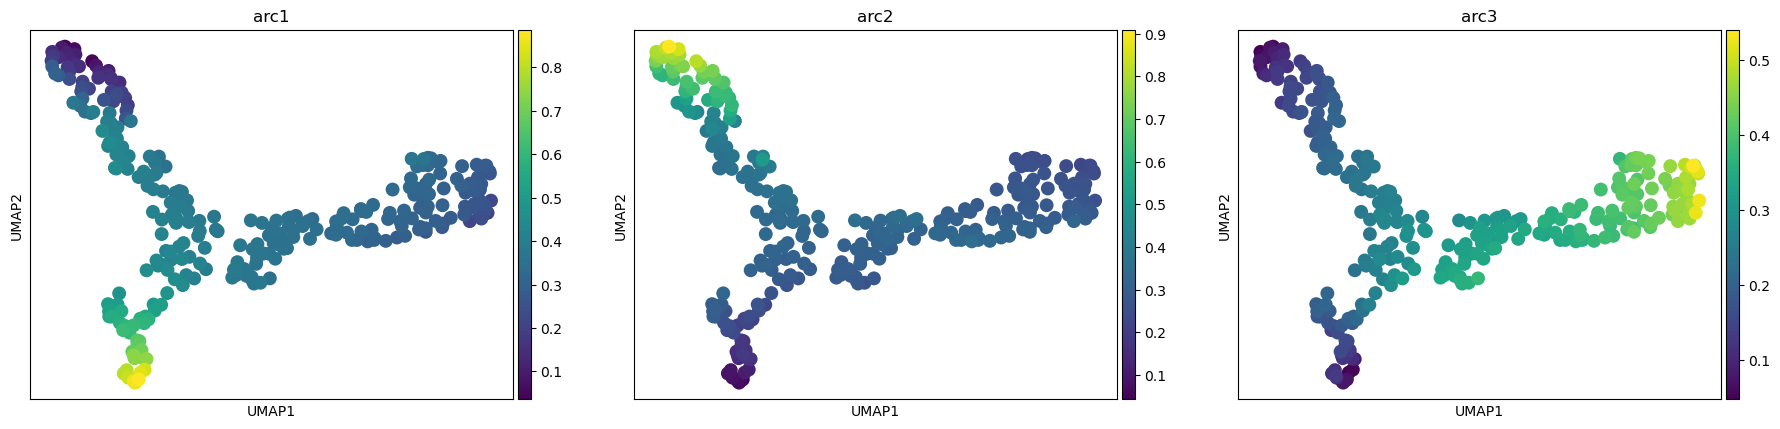

In [8]:
sc.pl.umap(data1_adata, color=arc_names1)

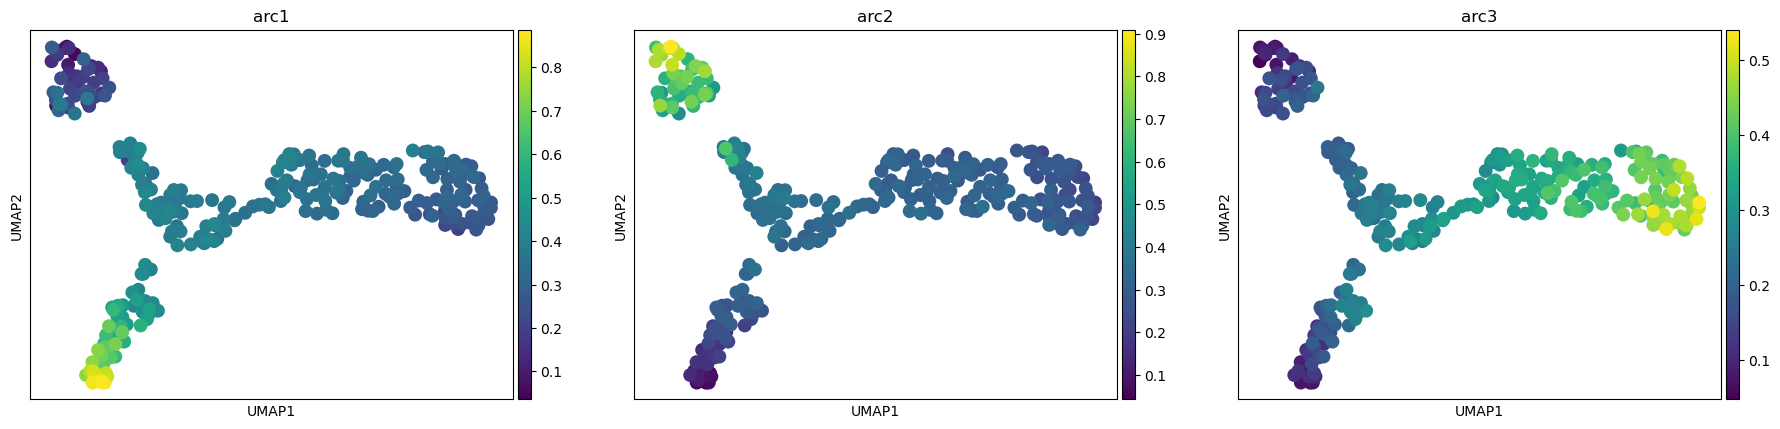

In [9]:
sc.pl.umap(data2_adata, color=arc_names2)

In [10]:
import mudata as md
from mudata import MuData 
import muon as mu

In [11]:
mdata = MuData({"data1": data1_adata, "data2": data2_adata})
mdata

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 300 × 3000
  2 modalities
    data1:	300 x 2000
      obs:	'arc1', 'arc2', 'arc3'
      uns:	'pca', 'neighbors', 'umap'
      obsm:	'X_pca', 'X_umap', 'X_aa'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    data2:	300 x 1000
      obs:	'arc1', 'arc2', 'arc3'
      uns:	'pca', 'neighbors', 'umap'
      obsm:	'X_pca', 'X_umap', 'X_aa'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'

In [18]:
_ = mu.tl.mofa(mdata, n_factors = 3)



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='data1' group='group1' with N=300 samples and D=2000 features...
Loaded view='data2' group='group1' with N=300 samples and D=1000 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: 

In [19]:
def add_MOFA_to_obs_adata(muon, adata):
    col_names = [ "factor" + str(i + 1) for i in np.arange(muon.obsm['X_mofa'].shape[1])]
    for i in range(len(col_names)):
        adata.obs[col_names[i]] = muon.obsm['X_mofa'][:,i]
    return adata, col_names

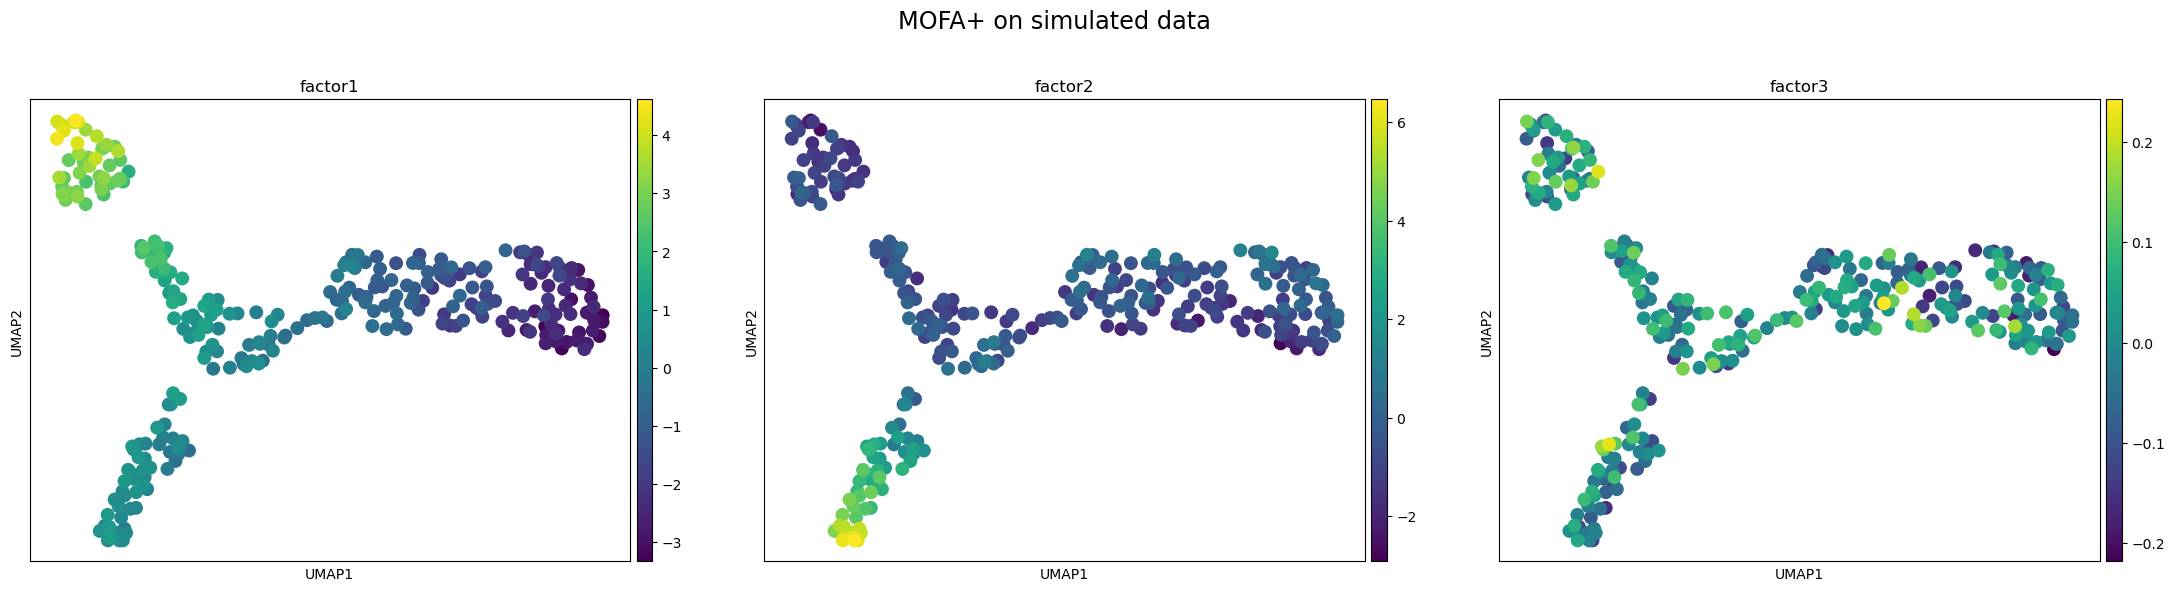

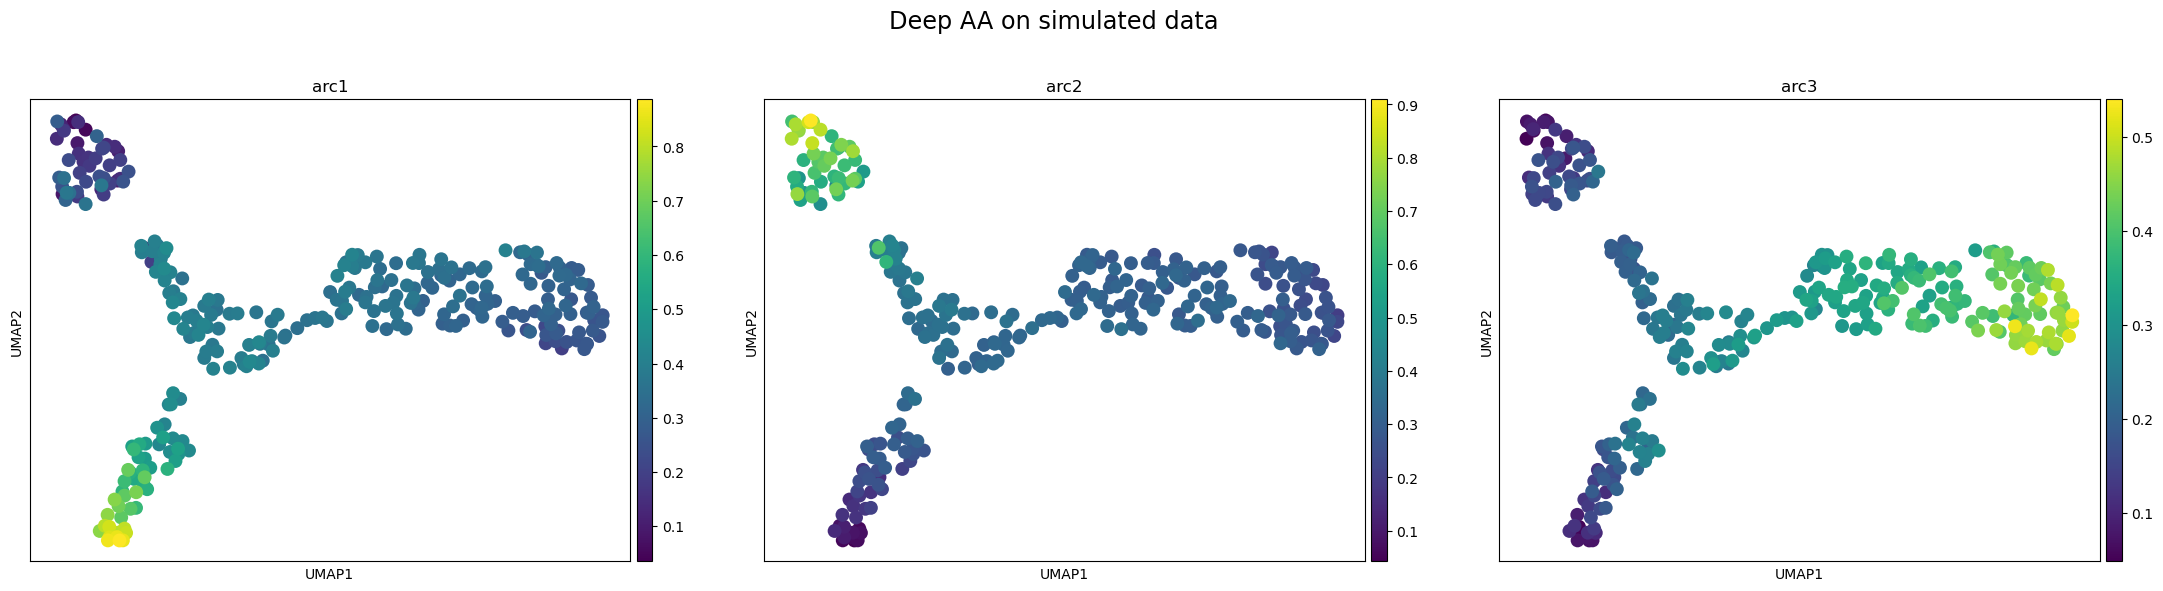

In [56]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

plt.rcParams["figure.autolayout"] = True



data2_adata, factor_names2 = add_MOFA_to_obs_adata(mdata, data2_adata)
sc.pl.umap(data2_adata, color=factor_names2, return_fig=True) 
plt.suptitle(f"MOFA+ on simulated data",fontsize = "xx-large", y = 1.05 , x = 0.45)
plt.show()
sc.pl.umap(data2_adata, color=arc_names2, return_fig=True) 
plt.suptitle(f"Deep AA on simulated data",fontsize = "xx-large", y = 1.05 , x = 0.45)
plt.show()
